In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize images to match model input
    return image, label

# Create train dataset 
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Modified from:
# train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# Change: Removed `.cache()` to lower RAM usage, since caching resized 224x224 images
#         would consume significant memory. Images are now resized on-the-fly.


# Create test dataset 
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Modified from:
# test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# Change: Removed `.cache()` to reduce RAM usage. Since the test set is small,
#         streaming with on-the-fly resizing is efficient enough.


In [4]:
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [5]:
# Train
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 819s 1s/step - accuracy: 0.6363 - loss: 1.0608 - val_accuracy: 0.7854 - val_loss: 0.6068
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 796s 1s/step - accuracy: 0.7663 - loss: 0.6680 - val_accuracy: 0.7971 - val_loss: 0.5789
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 779s 997ms/step - accuracy: 0.7880 - loss: 0.6131 - val_accuracy: 0.8067 - val_loss: 0.5614
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 774s 989ms/step - accuracy: 0.8006 - loss: 0.5789 - val_accuracy: 0.8066 - val_loss: 0.5553
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 774s 989ms/step - accuracy: 0.8050 - loss: 0.5571 - val_accuracy: 0.8151 - val_loss: 0.5329


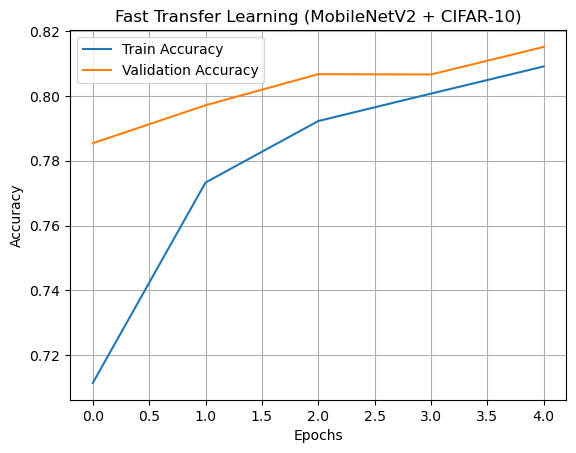

In [6]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Fast Transfer Learning (MobileNetV2 + CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()